<p align="center">
<img src='https://github.com/manuelmorgado/AQiPT/raw/main/resources/logo/aqipt_logo.png?raw=true' width="400" />
</p>


# Importing libraries

In [7]:
#libs
import numpy as np
import qutip as qt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from IPython.display import clear_output
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

import re,os, time, sys
from sys import setrecursionlimit
setrecursionlimit(10 ** 9)

from datetime import date

import itertools
from itertools import product
import functools
from functools import reduce

from typing import Iterator, List

import warnings
warnings.filterwarnings('ignore')

import networkx as nx

# import arc
import scipy as scp
import scipy.stats as stats

import multiprocessing as mp

color_lst = ['dodgerblue', 'red', 'blue', 'orange', 'green',
             'black', 'turquoise', 'magenta', 'yellow', 'maroon', 
             'lime', 'sienna', 'limegreen', 'violet', 'purple']; #list of colors

import AQiPT as aqipt
from AQiPT.modules.control import AQiPT_control as control
from AQiPT.modules.emulator import AQiPT_emulator as emulator
from AQiPT.modules.kernel import AQiPT_kernel as kernel


We start by checking the first developed classes in AQiPT.

We mainly will be using the classes:
  - Pulses
  - atomicModels
  - atomicQRegisters
  - atomSpecification

It is based in quantum master equation simulation powered by QuTiP package and do some other calculations
of atomic physics using Alkali Rydberg atom Calculator ARC also from python




# Creating pulses

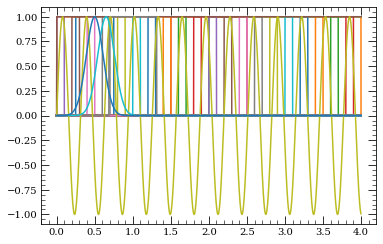

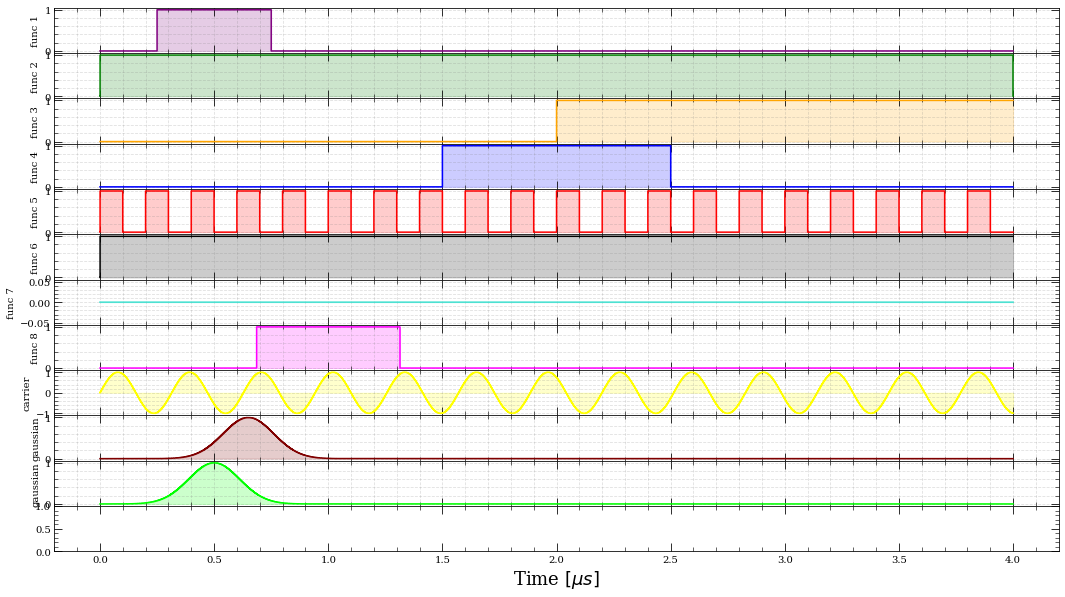

In [8]:
color_lst = ['purple', 'green', 'orange', 'blue', 'red',
             'black', 'turquoise', 'magenta', 'yellow', 'maroon', 
             'lime', 'sienna', 'limegreen', 'violet', 'dodgerblue']; #list of colors
             
nr_physical_ops = 11; #nr of physical operations

#PULSE SPECIFICATIONS
args = {'sampling':int(5e3), 'bitdepth':16, 'time_dyn':4}; #dictionary of general parameters introduced by user
pulse_params = aqipt.AQiPT_core.general_params(args); #get params AQiPT object from dictionary
tbase = pulse_params.timebase(); #obtain time-base from params object



nr_stroboscopic = 90;
twidth_pulse = 0.1; #us

#FUNCTION FOR PULSES
#function parameters
args_lst=[{'amp': 1, 't_o':0.5, 'width': 0.25, 'tp_window': pulse_params.dyn_time, 'name': 'func 1', 'color': color_lst[0], 'type': None},
         {'amp': 1, 't_o':2, 'width': 2,'tp_window': pulse_params.dyn_time, 'name': 'func 2', 'color': color_lst[1], 'type': None},
         {'amp': 1, 't_o':4, 'width': 2,'tp_window': pulse_params.dyn_time, 'name': 'func 3', 'color': color_lst[2], 'type': None},
         {'amp': 1, 't_o':2, 'width': 0.5,'tp_window': pulse_params.dyn_time, 'name': 'func 4', 'color': color_lst[3], 'type': None},
         {'amp': 1, 't_o':0.05, 'width':0.05,'tp_window': pulse_params.dyn_time, 'name': 'func 5', 'color': color_lst[4], 'type': 'stroboscopic'},
         {'amp': 1, 't_o':5, 'width': 5,'tp_window': pulse_params.dyn_time, 'name': 'func 6', 'color': color_lst[5], 'type': None},
         {'amp': 1, 't_o':5, 'width': 1,'tp_window': pulse_params.dyn_time, 'name': 'func 7', 'color': color_lst[6], 'type': None},
         {'amp': 1, 't_o':1, 'width': np.pi/10,'tp_window': pulse_params.dyn_time, 'name': 'func 8', 'color': color_lst[7], 'type': None},
         {'Amp':1, 'freq':20/(2*np.pi), 'phase':0,'tp_window': pulse_params.dyn_time, 'name': 'carrier', 'color': color_lst[8], 'type': None},
         {'g_Amp':1, 'g_center': 0.65, 'g_std':np.pi/40,'tp_window': pulse_params.dyn_time, 'name': 'gaussian', 'color': color_lst[9], 'type': None},
         {'g_Amp':1, 'g_center': 0.5, 'g_std':np.pi/40,'tp_window': pulse_params.dyn_time, 'name': 'gaussian', 'color': color_lst[10], 'type': None}];


'''
    control.function(tp, args_lst[_]).sinusoidal(plotON=True)
'''

#Generating the waveforms using the function AQiPT class
funcs_lst=[];
for _ in range(nr_physical_ops):

    #function creation
    tp_window = args_lst[_]['tp_window']; 
    
        
    if args_lst[_]['name'] == 'carrier':
        tp = np.linspace(0, tp_window, pulse_params.sampling);
        func, plot = control.function(tp, args_lst[_]).sinusoidal(plotON=False);
        funcs_lst.append(func);

    elif args_lst[_]['name'] == 'gaussian':
        tp = np.linspace(0, tp_window, int((tp_window-0)*pulse_params.sampling/pulse_params.dyn_time));
        func, plot = control.function(tp, args_lst[_]).gaussian(plotON=False);
        funcs_lst.append(func);

    else:
        tp = np.linspace(0, tp_window, int((tp_window-0)*pulse_params.sampling/pulse_params.dyn_time)); #time domain function
        func, plot = control.function(tp, args_lst[_]).step(plotON=False);
        funcs_lst.append(func);
    
    if args_lst[_]['type'] == 'stroboscopic':
        
        for _k in range(nr_stroboscopic):
                        
            args_lst[_]['t_o']+=twidth_pulse*2
            tp = np.linspace(0, tp_window, int((tp_window-0)*pulse_params.sampling/pulse_params.dyn_time));
            func, plot = control.function(tp, args_lst[_]).step(plotON=False);
            funcs_lst[_]=np.add(funcs_lst[_],func);

#plotting
fig, axs = plt.subplots(nr_physical_ops+1, 1, figsize=(18,10), sharex=True);
fig.subplots_adjust(hspace=0);
_=0;
for func in funcs_lst:
    
    #ploting
    axs[_].step(tp, func, color=args_lst[_]['color'], where='mid');
    axs[_].fill_between(tp, func, color=args_lst[_]['color'], step="mid", alpha=0.2);
    axs[_].set_ylabel(args_lst[_]['name']);
    axs[_].minorticks_on();
    axs[_].grid(b=True, which='both', color='gray', linestyle='--', alpha=0.25);
    plt.xlabel(r'Time $[\mu s]$', fontsize=18);
    
    _+=1;

# Creating atomicModels

Let's have a look into the core code again:

In [13]:
#atomicModel class

def basis_nlvl(n):
        '''
            Basis state for n-lvl system

            Creates the eigenbasis of the n-level system

            INPUTS:
            -------
            
                n : number of levels of the system

            
            OUTPUTS:
            --------
            
                basis_lst (array) : eigenbasis as array object in the order |1>, |2>...

        '''
        basis_lst = [qt.basis(n, state) for state in range(n)];
        return basis_lst#np.array(basis_lst, dtype=object)

def ops_nlvl(n, basis_lst = None):
    '''
        Operators basis for n-lvl system

        Creates the operators basis of the n-level system

        INPUTS:
        ------
            n : number of levels of the system
            basis_lst : list of the system eigenbasis

        
        OUTPUTS:
        -------
            proyectors (array) : operator basis as array object in the order |1><1|, |1><2|...
            basis (array) : eigenbasis as array object in the order |1>, |2>...

    '''
    if basis_lst == None:
        basis = basis_nlvl(n);
        proyectors = [ket1*ket2.dag() for ket1 in basis for ket2 in basis];

        return np.array(proyectors, dtype=object), basis
    else:
        basis = basis_lst;
        proyectors = [ket1*ket2.dag() for ket1 in basis for ket2 in basis];

        return proyectors

def iden(n):
    '''
        n-lvl identity operator

        Creates the identity operator for the n-level system

        INPUTS
            n : number of levels of the system

        OUTPUTS
            (QuTip object) : n by n square matrix with diagonal 1
    '''
    return qt.identity(n) #nxn identity operator

def lst2str(lst):
    return ''.join(str(e) for e in lst)

class atomicModel:
    
    """
        A class for develope models based in the n-level system of an atomic model. AQiPT atomicModel()
        class contain the basic toolbox for solve, time-dependent and -independent dynamics for 1 or
        more level physical atomic registers with the help of the AQiPT control-module using the class of 
        functions, pulses, tracks, sequence etc.

        The atomicModel class is the AQiPT core of the emulator for the dynamics of the quantum registers. 
        From this class is possible to generate and store the Hamiltonians, Lindbladians, Observables, quantum
        registers maps and plot results for later use of other modules of AQiPT.


        Parameters
        ----------
        times : array_like
            Time of dynamics to be emulated.
        Nrlevels : int
            Number of levels of the quantum system.
        initState : int
            Initial state for the dynamics starting from 0 to any n.
        params : dict
            Dictionary with parameters of dynamcis e.g., couplings, detunings, dissipators, pulses
        name : str
            Label for the model

        Attributes
        ----------
        times : array_like
            Time of dynamics to be emulated.
        Nrlevels : int
            Number of levels of the quantum system.
        initState : Qobj() [QuTiP]
            Initial density matrix.
        dynParams : dict
            Dictionary with parameters of dynamcis e.g., couplings, detunings, dissipators, pulses
        _lstHamiltonian : list_like
            List of the single body Hamiltonian
        Hamiltonian : Qobj() [QuTiP]
            Hamiltonian as QuTiP object
        Hpulses : list_like
            List of time-dependent function numpy array for QobjEvo() [QuTiP]
        tHamiltonian : QobjEvo() [QuTiP]
            Total time-dependent Hamiltonian of the atomicModel()
        cops : Qobj() list [QuTiP]
            List of Lindbladians as QuTiP objects
        mops : Qobj() list [QuTiP]
            List of Observables as QuTiP objects
        _ops : list
            Full list of operators that spam the system
        _basis : list 
            Full list of eigenstates of the system
        atomicMap :
            Graph object of the n-level system
        RydbergMap :
            Graph object of Rydberg states
        _graph
            netWorkx graph object.
        _name : str
            Name of the model AQiPT object
        simOpts : Qobj() [QuTiP]
            Options QuTiP object for the mesolve() master equation solver
        simRes : Qobj() list [QuTiP]
            List of Qobj() related to the density matrix rho as function of time
        __mode : str
            Mode of Hamiltonian, 'control' for pulsed Hamiltonian (i.e., time-dependent) or 'free' for no time-dependent

        Methods
        -------
        __init__()
            Constructor of atomicModel() AQiPT class
        playSim()
            Solve dynamics for the Nrlevels-system at initState using params.
        buildHamiltonian()
            Construct Hamiltonians as Qobj() QuTiP object (Hermitian)
        buildTHamiltonian()
            Construct time-dependent Hamiltonian as QobjEvo() QuTiP object (Hermitian)
        buildLindbladians()
            Construct Lindbladians as QuTiP object (Non-Hermitian)
        buildObservables()
            Construct Observables as QuTiP object (Hermitian)
        getResult()
            Return result values from simulation as a list of QuTiP objects (Hermitian)
        showResults()
            Plot results coming from the simulation
        modelMap()
            Plot the graph associated to the n-level system of the atomic quantum register
        
    """
    
    
    def __init__(self, times, Nrlevels, initState, params, name='atomicModel-defaultName', simOpt=qt.Options(nsteps=120000, rtol=1e-6, max_step=10e-6)):
        '''
            Constructor of the atomicQRegister() object of AQiPT
        '''
                
        #atributes
        
        self._ops, self._basis = ops_nlvl(Nrlevels); #eigenoperators and eigenbasis
        
        self.times = times;
        self.Nrlevels = Nrlevels;
        self._psi0 = initState;
        self.initState = self._basis[initState];
        
        self.dynParams = params;
        self._lstHamiltonian = []; #list of Hamiltonians of the system
        self.Hamiltonian = None; #total Hamiltonian of the model (single matrix)
        self.Hpulses = None; #time-dependency of the Hamiltonian a.k.a pulses
        self.tHamiltonian = None; #time-dependent Hamiltonian as QobjEvo() of QuTiP
        
        self.cops = None; #lindbladians
        self.mops = None; #observables


        self.atomicMap = {};
        self._graph = None;
        
        self._name = name;
        self.simOpts = simOpt;
        self.simRes = None;
        
        self.__mode = 'free'
    
    def playSim(self, mode='free'):
        '''
            Play the simulation of the dynamics of the atomicModel() object and store the results in the attribute simRes. Using the solver:

                QuTiP-QME : Quantum master equation solver by QuTiP
        '''
        
        if self.__mode=='free':
            self.simRes = qt.mesolve(self.Hamiltonian, qt.ket2dm(self.initState), self.times, c_ops=self.cops, e_ops=self.mops, options=self.simOpts);
        elif self.__mode=='control':
            self.simRes = qt.mesolve(self.tHamiltonian, qt.ket2dm(self.initState), self.times, c_ops=self.cops, e_ops=self.mops, options=self.simOpts);
    
    def buildTHamiltonian(self):
        '''
            Construct the time-dependent Hamiltonian of the atomicModel() and store it in the attribute tHamiltonian, the time-dependt pulses
            in Hpulses and the parts structure of the Hamiltonian in _lstHamiltonian.
            .
        '''
        
        self.__mode = 'control'
            
        _HQobjEVO = [];
        _HAQiPTpulses = [];
        
        for element in range(len(self.dynParams['couplings'])):
            
            _HStruct = self.dynParams['couplings']['Coupling'+str(element)][1] * (self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]] + self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]].dag());
            _HtDependency = self.dynParams['couplings']['Coupling'+str(element)][2];
            _HAQiPTpulses.append(_HtDependency);
            _HQobjEVO.append([_HStruct, _HtDependency]);
            self._lstHamiltonian.append(_HStruct);
        
        for element in range(len(self.dynParams['detunings'])):
            
            _HStruct = self.dynParams['detunings']['Detuning'+str(element)][1]*(self._ops[(self.dynParams['detunings']['Detuning'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['detunings']['Detuning'+str(element)][0])[1]] );
            _HtDependency = self.dynParams['detunings']['Detuning'+str(element)][2];
            _HAQiPTpulses.append(_HtDependency);
            _HQobjEVO.append([_HStruct, _HtDependency]);
            self._lstHamiltonian.append(_HStruct);
            
        self.tHamiltonian = _HQobjEVO;
        self.Hpulses = _HAQiPTpulses;
    
    def buildHamiltonian(self):
        '''
            Construct the Hamiltonian of the atomicModel() in two parts: 1) the total diagonal terms and the total off-diagonal terms,
            finally sum them up and store it in the attribute Hamiltonian.
        '''
        HD = sum([self.dynParams['couplings']['Coupling'+str(element)][1] * (self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]] + self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]].dag()) for element in range(len(self.dynParams['couplings'])) ]);
        HoffD = sum([self.dynParams['detunings']['Detuning'+str(element)][1]*(self._ops[(self.dynParams['detunings']['Detuning'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['detunings']['Detuning'+str(element)][0])[1]] ) for element in range(len(self.dynParams['detunings'])) ]);
        self.Hamiltonian = HD + HoffD;
    
    def buildLindbladians(self):
        '''
            Construct Lindbland terms for the Quantum master equation solver of QuTiP.
        '''
        self.cops = [np.sqrt(self.dynParams['dissipators']['Dissipator'+str(element)][1])*(self._ops[(self.dynParams['dissipators']['Dissipator'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['dissipators']['Dissipator'+str(element)][0])[1]]) for element in range(len(self.dynParams['dissipators']))];
    
    def buildObservables(self):
        '''
            Construct Observable operators for the Quantum master equation solver of QuTiP.
        '''
        self.mops = [self._ops[(self.Nrlevels+1)*i] for i in range(self.Nrlevels)];
        
    def getResult(self):
        '''
            Return the values of the simulation executed with playSim().
        '''
        return self.simRes
    
    def showResults(self, resultseq=None, sizefig=(15,9)):
        '''
            Returns the matplotlib fig and axis, showing the results from the Simulation using playSim().
        '''
        
        if resultseq==None:
            resultseq = self.simRes;
        
        fig, axs = plt.subplots(figsize=sizefig);

        for i in range(len(resultseq.expect)):
            axs.plot(times, resultseq.expect[i], label=i, alpha=0.5, linewidth=1.5);

        plt.legend();
        plt.xlabel('Time', fontsize=18);
        plt.ylabel('Population', fontsize=18);

        return fig, axs
    
    def modelMap(self, plotON=True):
        '''
            Construct and return the Graph plot and Lindbland terms for the Quantum master equation solver of QuTiP.
        '''
        #
        for state in range(self.Nrlevels):
            self.atomicMap[state] = [];
            
        #setting edges
        for coupling in self.dynParams['couplings'].items():
            i, j = coupling[1][0];
            self.atomicMap[i].append(j);
            self.atomicMap[j].append(i);
        
        edge_list = [];
        for dissipator in self.dynParams['dissipators'].items():    
            i,j = dissipator[1][0];
            if i==j:
                edge_list.append(tuple([i,j]));
                
        G = nx.MultiDiGraph(self.atomicMap, create_using=nx.DiGraph, seed = 100);
        
        #edges for dephasing
        G.add_edges_from(edge_list);
              
        if 'rydbergstates' in self.dynParams:
            color_map = ['m' if node in self.dynParams['rydbergstates']['RydbergStates'] else 'dodgerblue' for node in G] 
        else:
            color_map = 'mediumseagreen'
            
        #plotting
        if plotON==True:
            pos = nx.circular_layout(G);
            nx.draw(G, with_labels=True, font_weight='regular', node_color=color_map, node_size=400, linewidths=7, font_size=15);
            nx.draw_networkx_edges(G, pos, edgelist=edge_list, arrowstyle="<|-", style="solid");
            
        self._graph = {'graph': G, 'colormap':color_map, 'edges': edge_list}; #store the graph in attribute

        return self.atomicMap
 

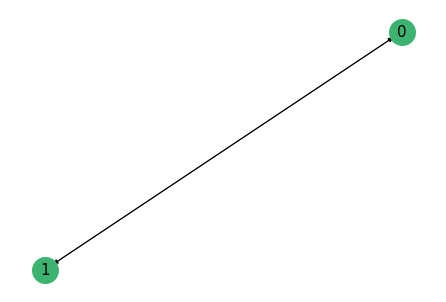

In [36]:
Nrlevels = 10; #nr of levels in the system {|0>, |1>}
psi0 = 0; #initial state |0>
"""
coupling0 -> CouplingRed-767nm
Detuning0 -> omega*sigmax+delta*sigmaz

      drho/dt = [H, rho] + lindbladian (Quantum Master Equation)

"""
times = np.linspace(0, 10, 500); #time of the dynamics
couplings = {'Coupling0': [[0,1], 2*np.pi*0.7,  None]}; #couplings list within the states [i,j], couplingValue, pulse
detunings = {'Detuning0': [[1,1], -2*np.pi*0.1,  None]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators = {'Dissipator0': [[0,1], 2*np.pi*0.0]}; #dissipator list within the states [i,j], dissipatorStrenght


params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators}; #wrapping dynamic params in dictionary

qubit = atomicModel(times, Nrlevels, psi0, params, name = '2-lvl')#, NrQReg=1, Homogeneous=True); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

qubitMap = qubit.modelMap(plotON=True); #defining the map of the AtomicQuantumRegister

In [37]:
qubit.buildHamiltonian(); #building Hamiltonians
qubit.buildLindbladians(); #building Lindbladians
qubit.buildObservables(); #building Observables

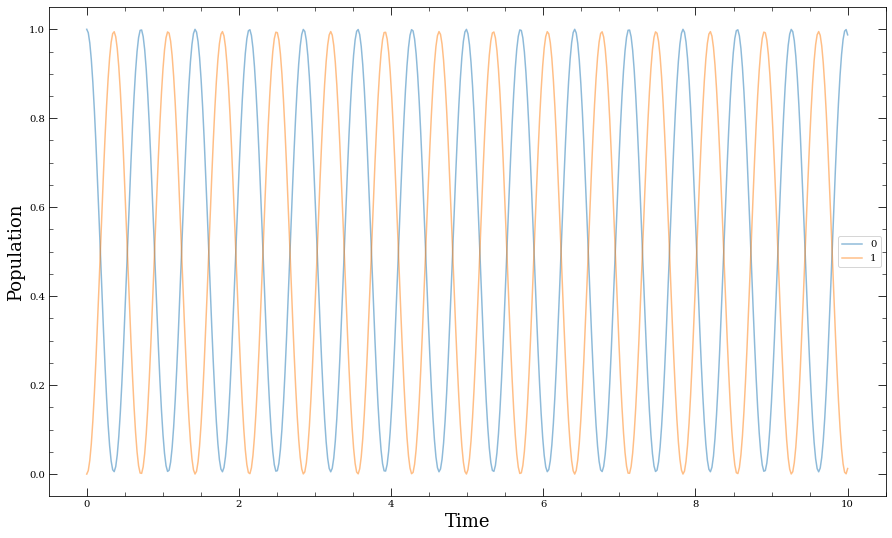

In [38]:
qubit.playSim(); #playing simulation
qubit.showResults(); #showing simulation results

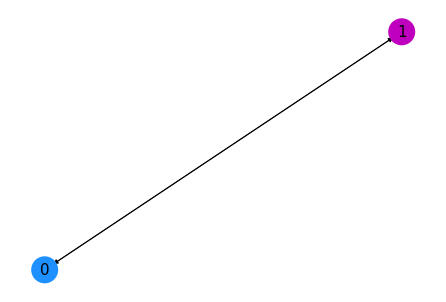

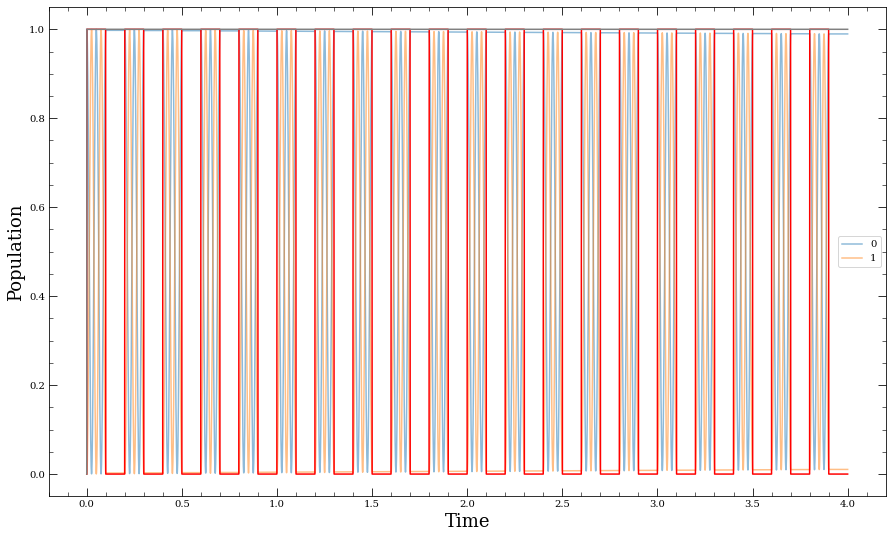

In [46]:
#PULSED QUBIT 1
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state

times = pulse_params.timebase(); #time of the dynamics

couplings_q1 = {'Coupling0': [[0,1], 2*np.pi*10, funcs_lst[4]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings_q1 = {'Detuning0': [[1,1], -2*np.pi*0., funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators_q1 = {'Dissipator0': [[0,1], 2*np.pi*0.00219]}; #dissipator list within the states [i,j], dissipatorStrenght
Rydbergstates_q1 = {'RydbergStates': [1], 'l_values':[0]}; #label the Rydberg states

sim_params_q1 = {'couplings': couplings_q1,
                 'detunings': detunings_q1,
                 'dissipators': dissipators_q1,
                 'rydbergstates': Rydbergstates_q1}; #wrapping dynamic params in dictionary

pulsed_qubit1 = atomicModel(times, Nrlevels, psi0, sim_params_q1, name = 'qubit 1'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

pulsed_qubit2_Map = pulsed_qubit1.modelMap(plotON=True); #defining the map of the AtomicQuantumRegister

pulsed_qubit1.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qubit1.buildLindbladians(); #building Lindbladians
pulsed_qubit1.buildObservables(); #building Observables
pulsed_qubit1.playSim(mode='control'); #playing simulation
pulsed_qubit1.showResults(); #ploting

plt.plot(times, funcs_lst[4], color='red');
plt.plot(times, funcs_lst[5], color='gray');

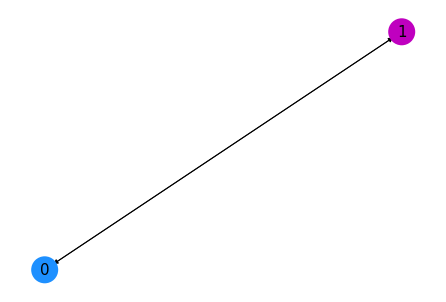

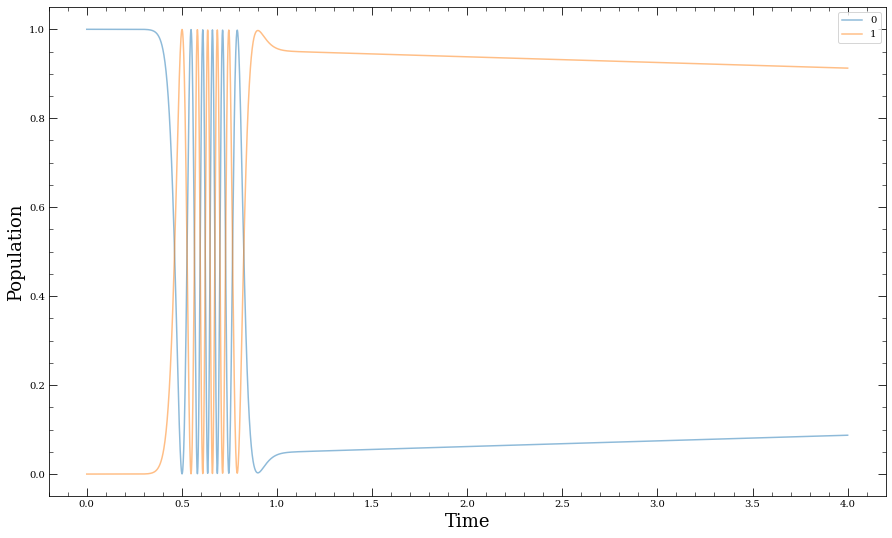

In [47]:
#PULSED QUBIT 2
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state

times = pulse_params.timebase(); #time of the dynamics

couplings_q2 = {'Coupling0': [[0,1], 2*np.pi*10, funcs_lst[9]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings_q2 = {'Detuning0': [[1,1], -2*np.pi*0., funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators_q2 = {'Dissipator0': [[0,1], 2*np.pi*0.00219]}; #dissipator list within the states [i,j], dissipatorStrenght
Rydbergstates_q2 = {'RydbergStates': [1], 'l_values':[0]}; #label the Rydberg states

sim_params_q2 = {'couplings': couplings_q2, 
                 'detunings': detunings_q2, 
                 'dissipators': dissipators_q2,
                 'rydbergstates': Rydbergstates_q2}; #wrapping dynamic params in dictionary

pulsed_qubit2 = emulator.atomicModel(times, Nrlevels, psi0, sim_params_q2, name = 'qubit 2'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

pulsed_qubit2_Map = pulsed_qubit2.modelMap(plotON=True); #defining the map of the AtomicQuantumRegister

pulsed_qubit2.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qubit2.buildLindbladians(); #building Lindbladians
pulsed_qubit2.buildObservables(); #building Observables
pulsed_qubit2.playSim(mode='control'); #playing simulation
pulsed_qubit2.showResults(); #ploting

# plt.fill(times, funcs_lst[7], color='red', alpha=0.2);
# plt.fill(times, funcs_lst[5], color='gray', alpha=0.2);

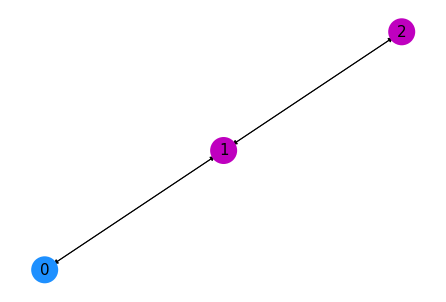

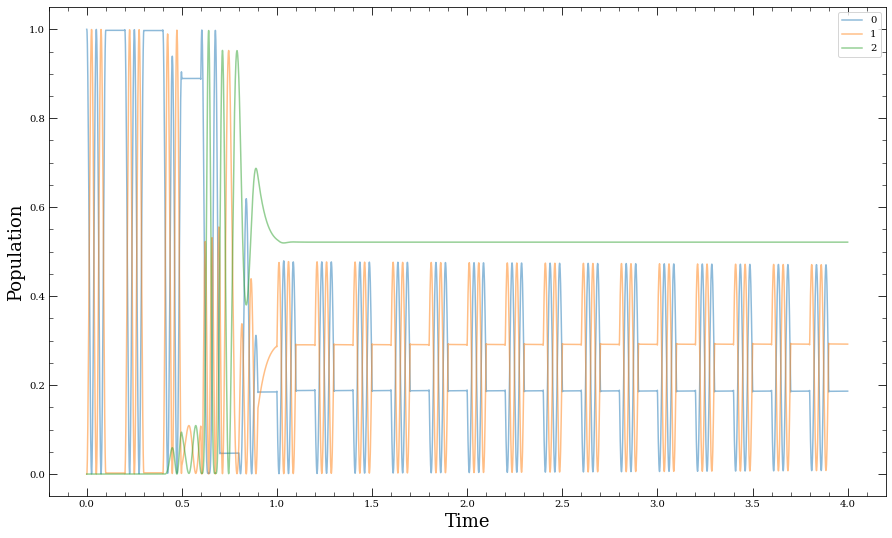

In [50]:
#PULSED QUTRIT 1
Nrlevels = 3; #nr of levels in the system
psi0 = 0; #initial state

times = pulse_params.timebase(); #time of the dynamics

couplings_q3 = {'Coupling0': [[0,1], 2*np.pi*10, funcs_lst[4]],
                'Coupling1': [[1,2], 2*np.pi*10, funcs_lst[9]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings_q3 = {'Detuning0': [[1,1], -2*np.pi*0., funcs_lst[5]],
                'Detuning1': [[1,1], -2*np.pi*0., funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators_q3 = {'Dissipator0': [[0,1], 2*np.pi*0.00219],
                  'Dissipator0': [[0,1], 2*np.pi*0.00219]}; #dissipator list within the states [i,j], dissipatorStrenght
Rydbergstates_q3 = {'RydbergStates': [1,2], 'l_values':[0, 1]}; #label the Rydberg states

sim_params_q3 = {'couplings': couplings_q3, 
                 'detunings': detunings_q3, 
                 'dissipators': dissipators_q3,
                 'rydbergstates': Rydbergstates_q3}; #wrapping dynamic params in dictionary

pulsed_qutrit1 = emulator.atomicModel(times, Nrlevels, psi0, sim_params_q3, name = 'qutrit 1'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

pulsed_qutrit1_Map = pulsed_qutrit1.modelMap(plotON=True); #defining the map of the AtomicQuantumRegister

pulsed_qutrit1.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qutrit1.buildLindbladians(); #building Lindbladians
pulsed_qutrit1.buildObservables(); #building Observables
pulsed_qutrit1.playSim(mode='control'); #playing simulation
pulsed_qutrit1.showResults(); #ploting

# plt.plot(times, funcs_lst[9], color='red');
# plt.plot(times, funcs_lst[10], color='gray');
# plt.plot(times, funcs_lst[5], color='darkblue');

# Creating a Quantum Register

Let's have a short look into the core code

In [26]:
def perm_w_repl(n: int, m: int) -> Iterator[List[int]]:
    cur = []

    def perm_w_repl_recur(n_rec: int, m_rec: int) -> Iterator[List[int]]:
        nonlocal cur

        if n_rec == 0:
            yield cur
            return

        for i in range(1, m_rec + 1):
            cur = cur + [i]
            yield from perm_w_repl_recur(n_rec - 1, m_rec)
            cur.pop()

    yield from perm_w_repl_recur(n, m)

#transform from list to string
def lst2string(lst):
    return ''.join(str(e) for e in lst)

#convert bit-string to string
def bitstring2lst(string): 
    list1=[] 
    list1[:0]=string 
    return [ int(x) for x in list1 ] 

#transformation of qudit bit-string to qudit ket
def nqString2nqKet(psi0_string, bitdim=2, bitsdim=None):
    if bitsdim==None:
        ket_lst = [c for c in psi0_string];
        psi = qt.Qobj();    
        counter=0;
        for i in range(len(ket_lst)):
            if counter==0:
                psi = qt.ket(ket_lst[i],bitdim);
                counter+=1;
            else:
                psi= qt.tensor(psi, qt.ket(ket_lst[i],bitdim));
        return psi
    else:
        ket_lst = [c for c in psi0_string];
        psi = qt.Qobj();    
        counter=0;
        for i in range(len(ket_lst)):
            if counter==0:
                psi = qt.ket(ket_lst[i],bitsdim[i]);
                counter+=1;
            else:
                psi= qt.tensor(psi, qt.ket(ket_lst[i],bitsdim[i]));
        return psi

#generate binary bit-strings of n-bits and k-ones in bit
def bitCom(n, k):
    result = []
    for bits in itertools.combinations(range(n), k):
        s = ['0'] * n
        for bit in bits:
            s[bit] = '1'
        result.append(''.join(s))
    return result

#generate non-binary bit-strings of nr_at atoms and qdim qudit dimension
def mbitCom(nr_at=1, qdim=3):
    lst_comb=[];

    for i in perm_w_repl(nr_at, qdim):
        lst_comb.append([e - 1 for e in [*i]])
    return lst_comb

#set observables of dim^n Hilbert space system
def obs(at_nr, qdim=2):
    if qdim==2:
        print('=2')
        bit_lst = [];
        for i in range(at_nr+1):
            bit_lst+=bitCom(at_nr,i);
        obs_lst = [];
        for e in bit_lst:
            ket = qt.basis([qdim]*at_nr, bitstring2lst(e));
            obs_lst.append((ket* ket.dag()) )
        obs_tot = sum(obs_lst)
        #possible to graphically check with: qt.matrix_histogram_complex(obs_tot)
        return obs_lst, bit_lst
    if qdim!=2:
        bit_lst = [lst2string(i) for i in mbitCom(at_nr, qdim)];
        obs_lst = [qt.basis(qdim, i)*qt.basis(qdim, i).dag() for i in range(qdim)];
        print(len(obs_lst))
        return obs_lst, bit_lst

#caculate operatos of interaction
def rydbergInteraction(qubit_nr, interacting_atoms, qdim=2):
    '''
        Rydberg Interaction operators

        Calculates the blockade interaction operator coming from all-to-all interactions 
        with certain number of interacting atoms

        INPUTS:
        -------
            at_nr (int) : atom number in the blockade radius / (sub-)ensemble
            interacting_atoms (int) : number of remaining atoms in the GS and within
            qdim (int) : dimension of the atoms conside

        OUTPUTS:
        --------
    '''
    rr_op = qt.basis(qdim,qdim-1)*qt.basis(qdim,qdim-1).dag()

    rri_rrj_op = [];
    for i in interacting_atoms:
        op_list = [qt.qeye(qdim) for i in range(qubit_nr)];
        op_list[i] = rr_op;
        rri_rrj_op.append(qt.tensor(op_list))
    return rri_rrj_op

class atomicQRegister:
    
    """
        A class for develope models based in the n-level system of an atomic register. AQiPT atomicQRegister()
        class contain the basic toolbox for solve, time-dependent and -independent dynamics for 1 or
        more physical atomic atomicModel() objects with the help of the AQiPT control-module using the class of 
        functions, pulses, tracks, sequence etc.

        The pulse class is the AQiPT core of the emulator for the dynamics of quantum registers based in atomic
        systems. From this class is possible to generate and store the Hamiltonians, Lindbladians, Observables, quantum
        registers maps and plot results for later use of other modules of AQiPT.


        Parameters
        ----------
        physicalRegisters : array
            Time of dynamics to be emulated.
        Nrlevels : int
            Number of levels of the quantum system.
        initnState : int
            Initial state for the dynamics starting from 0 to any n.
        params : dict
            Dictionary with parameters of dynamcis e.g., couplings, detunings, dissipators, pulses
        name : str
            Label for the model

        Attributes
        ----------
        _AMs : list_like
            List of atomicModel() objects
        AMconfig : 
            Configuration attribute of the registers given by spacial disposition.
        times : array
            Time of dynamics to be emulated from the first atomicModel object.
        lstNrlevels : list_like
            List of the number of levels of the atomicModels() or registers
        Nrlevels : int
            Number of levels of the quantum system.
        NrQReg : int
            Number of atomicModel() or registers
        initnState : Qobj() [QuTiP]
            Initial state of the density matrix of the full atomicQRegister.
        lstinitState : list_like
            List of the initial state of the atomicModel() AQiPT class.
        dynParams : dict
            Dictionary with parameters of dynamic parameter of the registers i.e., couplings, detunings, dissipators, pulses
        lstHamiltonian : list_like
            List of full Hamiltonian of the atomicModel class.
        _lsttHamiltonian : list_like
            List of the time-dependent Hamiltonian Qobj() [QuTiP] class
        lstPulses : list_like
            List of time-dependent function numpy array
        nHamiltonian : Qobj() [QuTiP]
            Hamiltonian of the full Hilbert space as QuTiP object
        tnHamiltonian : Qobj() [QuTiP]
            Time-dependent Hamiltonian of the full Hilbert space
        Hpulses : list_like
            List of time-dependent function numpy array for QobjEvo() [QuTiP]
        lstcops : list_like
            List of collapse operators of the system for the Lindbland term
        ncops : Qobj() list [QuTiP]
            List of Lindbladians as Qobj() QuTiP class
        lstmops : list_like
            List of measurement operators of the system for the Lindbland term
        nmops : Qobj() list [QuTiP]
            List of Observables as Qobj() QuTiP class
        _ops : list
            Full list of operators that spam the system
        _basis : list 
            Full list of eigenstates of the system
        atomicRegister :
            Graph object of the n-level registers
        _graph :
            networkx Graph object of the NrQReg-atomicModel()
        _name : str
            Name of the atomicQRegister() AQiPT class
        _homogeneous : Bool 
            Quantum register homogeneity of the number of levels in each register            
        simOpts : Qobj() [QuTiP]
            Options QuTiP object for the mesolve() master equation solver
        simRes : Qobj() list [QuTiP]
            List of Qobj() related to the density matrix rho as function of time
        __mode : str
            Mode of Hamiltonian, 'control' for pulsed Hamiltonian (i.e., time-dependent) or 'free' for no time-dependent
        connectivity : list
            Map of connectivity between physical registers via Rydberg states. Blind to the interaction strength
        layout : list
            Map of spatial distribution of physical registers

        Methods
        -------
        __init()__
            Contructor of the atomicQResgister() AQiPT class
        playSim()
            Solve dynamics of the physicalRegisters of atomicModel() with different or same Nrlevels-system at initState using dynparams.
        buildNinitState()
            Construct NrQReg initial state of the atomicQRegister as Qobj() [QuTiP] class
        buildNHamiltonian()
            Construct  NrQReg dimensional  Hamiltonian of the atomicQRegister as Qobj() [QuTiP] class (Hermitian)
        buildTNHamiltonian()
            Construct time-dependent  NrQReg dimensional  Hamiltonian of the atomicQRegister as QobjEvo() [QuTiP] class (Hermitian)   
        buildNLindbladians()
            Construct  NrQReg dimensional Lindbladians as Qobj() [QuTiP] class (Non-Hermitian)
        buildNObservables()
            Construct NrQReg dimensional Observables as Qobj() [QuTiP] class (Hermitian)
        add2QRegister()
            Add new model to the atomicQRegister() from parameters or from a predefined atomicModel()
        getNHamiltonian()
            Return NrQReg dimensional Hamiltonian of the atomicQRegister as QobjEvo() [QuTiP] class (Hermitian)   
        getNLindbladian()
            Return NrQReg dimensional Lindbladians as [QuTiP] class (Non-Hermitian)
        getNObservables()
            Return NrQReg dimensional Observables as [QuTiP] class (Hermitian)
        getResult()
            Return result values from simulation as a list of QuTip objects (Hermitian)
        showResults()
            Plot results coming from the simulation
        registerMap()
            Plot the graph associated atomicQRegister()
            
    """

    def __init__(self, physicalRegisters, initnState=None, name='atomicQRegister-DefaultName', 
                 times=None, NrQReg=None, homogeneous=True, lstNrlevels=None,
                 connectivity=['All'], layout=None, map=[]):
        '''
            Constructor of the atomicQRegister() object of AQiPT
        '''
                
        #atributes
        
        self._AMs = physicalRegisters;
        self.AMconfig = None;
        

        if times == None:
            self.times = self._AMs[0].times;
        else:
            self.times = times;
        
        if lstNrlevels==None:
            self.lstNrlevels = [AM.Nrlevels for AM in self._AMs];
        else:
            self.lstNrlevels = lstNrlevels;
        self.Nrlevels = reduce(lambda x, y: x * y, self.lstNrlevels);
        self._levels = None;
        self.NrQReg = len(self._AMs);

        self.__HilbertSpaceSize = sum(self.lstNrlevels);
        self._HSlist = [];

        self.initnState = None;
        if initnState==None:
            self.lstinitState = [AM.initState for AM in self._AMs];
        else:
            self.lstinitState = bitstring2lst(initnState);
        
        self.dynParams = [AM.dynParams for AM in self._AMs];
        
        self.lstHamiltonian = [AM.Hamiltonian for AM in self._AMs];
        self._lsttHamiltonian = [];
        self.lstPulses = [AM.Hpulses for AM in self._AMs];
        self.nHamiltonian = None;
        self.tnHamiltonian = None;
        self.Hpulses = None;
        
        self.lstcops = [AM.cops for AM in self._AMs];
        self.ncops = None;
        
        self.lstmops = [AM.mops for AM in self._AMs];
        self.nmops = [];
        
        self._ops, self._basis = ops_nlvl(self.Nrlevels);
        self._basisString = [];
        self._basis = [];
        self._intbasis = [];
        self._pairInteraction_idx = [];
        self._pairInteraction_lval = [];

        self.nC6Interaction = None;
        self.nC3Interaction = None;

        self._graphRegister = None;
        self._graphscolors = None;
        self._rydbergstates = [];
        
        _Hcount=0;
        for i in range(len(self._AMs)):
            _HS_AMS=[];
            for _rydState in self._AMs[i].dynParams['rydbergstates']['RydbergStates']:
                self._rydbergstates.append( _rydState + _Hcount);
                _HS_AMS.append(_rydState + _Hcount);
            self._HSlist.append(_HS_AMS);    
            _Hcount+=self._AMs[i].Nrlevels;
        if connectivity[0]=='All':
            self.connectivity = connectivity;
        elif connectivity[0]=='Bidirected':
            self.connectivity = connectivity[1] + [tuple(np.flip(i)) for i in connectivity[1]];
        elif connectivity[0]=='Directed':
            self.connectivity = connectivity[1];
        self._connectivityType = connectivity[0];

        self.layout = layout;

        self.map = [];
        self._graphMap = None;

        self.compileQRegister = {};

        self._name = name;
        self._homogeneous = homogeneous;
        self.simOpts = qt.Options(nsteps=500, rtol=1e-7, max_step=10e-1);
        self.simRes = None;
        self.__mode = 'free';

        
    def compile(self):

        Q = nx.MultiDiGraph({}, create_using=nx.DiGraph, seed=100);

        for connection in self.connectivity:
            #define nodes ith and jth
            node_i = connection[0];
            node_j = connection[1];

            #if the nodes does not coincide
            if node_i!=node_j:

                _pairNodes = [None, None]; #set of node pairs
                
                for node in self._HSlist:
                    if node_i in node:
                        _pairNodes[0] = self._HSlist.index(node); #for the ith node in the node of qubit kth, connect to the jth node in the node of qubit nth
                for node in self._HSlist:
                    if node_j in node:
                        _pairNodes[1] = self._HSlist.index(node);#for the jth node in the node of qubit kth, connect to the ith node in the node of qubit nth
                
                if _pairNodes not in self.map:
                    self.map.append(_pairNodes);

        Q.add_edges_from(self.map);
        
        plt.figure();
        nx.draw(Q, with_labels=True);

        self._graphMap = Q; #set graph of the qubit map
        
        for n in range(self.NrQReg):
            
            #positions of atoms
            _nqPosition =self.layout[n];

            #QRegister map
            _qMap = [];
            for edge in self.map:
                if n in edge:
                    _qMap.append(edge);

            #connectivity
            _connectivity=[];
            for kqstates in self._HSlist[n]:
                _connectivity+=[edge for edge in self.connectivity if kqstates in edge]


            _nqDetails = {'Position': _nqPosition, 'qMap':_qMap, 'Connectivity': _connectivity};
            _nqLabel = 'q'+str(n);

            self.compileQRegister.update({_nqLabel: _nqDetails}); #store QRegister details/specs


        print('no implemented completely yet')

    def playSim(self, mode='free', solver='QuTiP-QME'):
        '''
            Play the simulation of the dynamics of the atomicQRegister() object and store the results in the attribute simRes. Using the solver:
            
                QuTiP-QME : Quantum master equation solver by QuTiP
            
        '''
        
        if solver=='QuTiP-QME':
            if self.__mode=='free':
                self.simRes = qt.mesolve(self.nHamiltonian, qt.ket2dm(self.initnState), self.times, c_ops=self.ncops, e_ops=self.nmops, options=self.simOpts)

            elif self.__mode=='control':
                self.simRes = qt.mesolve(self.tnHamiltonian, qt.ket2dm(self.initnState), self.times, c_ops=self.ncops, e_ops=self.nmops, options=self.simOpts)
    
    def buildNBasis(self):

        _basis_set = list(itertools.product(*self.lstNrlevels));

        for basis in _basis_set:
            _basisString.append(lst2string(basis));
            _basis.append(nqString2nqKet(lst2string(basis), None, bitsdim=self.lstNrlevels));
    
    def _buildInteractingBasis(self):
        '''
            Build the basis for the interactions basis in the connectivity map, that represent the interactions
            between Rydberg states 
        '''

        _pairInteraction_idx = [];
        _interaction_ops=[];
        for connection in self.connectivity:
            Vij = None;
            ri = connection[0];
            rj = connection[1];

            _idx_ij = [];
            _PSI = [[] for _ in range(len(self._AMs))];
            _PSI_dag = [[] for _ in range(len(self._AMs))]; #copy of _PSI for building off diagonal terms of the type |rirjXrjri| (i.e., V_{d-d})
            _klst = list(range(len(self._AMs)));
            for k in range(len(self._HSlist)):
                if ri in self._HSlist[k]:
                    _ri_ket = qt.basis(self.lstNrlevels[k], self.lstNrlevels[k] - (len(self._HSlist[k])-self._HSlist[k].index(ri)) );
                    _PSI[k] = _ri_ket;
                    _ri_ket_idx = k;
                    if k in _klst:
                        _klst.pop(_klst.index(k));
                    _idx_ij.append(_ri_ket_idx);

                if rj in self._HSlist[k]:
                    _rj_ket = qt.basis(self.lstNrlevels[k], self.lstNrlevels[k] - (len(self._HSlist[k])-self._HSlist[k].index(rj)) );
                    _PSI[k] = _rj_ket;
                    _rj_ket_idx = k;
                    if k in _klst:
                        _klst.pop(_klst.index(k));
                    _idx_ij.append(_rj_ket_idx);

            #build the composed ket for the |rirjXrjri| (i.e., V_{d-d})
            _PSI_dag[_rj_ket_idx] = _ri_ket;
            _PSI_dag[_ri_ket_idx] = _rj_ket;


            _bufEigenstates=[];
            for k in _klst:
                _bufEigenstates.append([qt.basis(self.lstNrlevels[k], eigenstate) for eigenstate in range(self.lstNrlevels[k]-len(self._HSlist[k]))]); #not allowing 3rths Rydberg states
                
            for combin in itertools.product(*_bufEigenstates):
                _c=0; #initialize counter for the element of the combination
                for _idx in _klst:
                    _PSI[_idx]=combin[_c]; #substitute the GS eigenstates of the _idx Hilbert space in the _klst of HS not used to locate ri & rj
                    _PSI_dag[_idx]=combin[_c]; #substitute the GS eigenstates of the _idx Hilbert space in the _klst of HS not used to locate rj & ri
                    _c+=1; #next element of the combination

                l_i = self.dynParams[_ri_ket_idx]['rydbergstates']['l_values'][(len(self._HSlist[_ri_ket_idx])-self._HSlist[_ri_ket_idx].index(ri))-1];
                l_j = self.dynParams[_rj_ket_idx]['rydbergstates']['l_values'][(len(self._HSlist[_rj_ket_idx])-self._HSlist[_rj_ket_idx].index(rj))-1];
                self._pairInteraction_lval.append([l_i, l_j]);

                if isinstance(Vij, qt.Qobj):
                    if l_i==l_j: #if li=lj check V_{vdW} or V_{d-d}
                        Vij+=qt.tensor(_PSI)*qt.tensor(_PSI).dag(); #|rirjXrirj| 
                    else:
                        _Vop = qt.tensor(_PSI)*qt.tensor(_PSI_dag).dag();
                        _Vopdag = (qt.tensor(_PSI)*qt.tensor(_PSI_dag).dag()).dag();
                        _Vopdag.dims = _Vop,dims;
                        Vij+= _Vop + _Vopdag; #|rirjXrjri| + h.c
                else:
                    if l_i==l_j: #if li=lj check V_{vdW} or V_{d-d}
                        Vij =qt.tensor(_PSI)*qt.tensor(_PSI).dag(); #|rirjXrirj|
                    else:
                        _Vop = qt.tensor(_PSI)*qt.tensor(_PSI_dag).dag();
                        _Vopdag = (qt.tensor(_PSI)*qt.tensor(_PSI_dag).dag()).dag();
                        _Vopdag.dims = _Vop.dims;
                        Vij = _Vop + _Vopdag; #|rirjXrjri| + h.c

            Vij.dims = [[self.Nrlevels],[self.Nrlevels]];
            _interaction_ops.append(Vij);
            self._intbasis = _interaction_ops;
            if _idx_ij not in self._pairInteraction_idx:
                self._pairInteraction_idx.append(_idx_ij);

    def buildNinitState(self):
        '''
            Construct the initial state for the N atomicModel() that constitute the atomicQRegister() and store it in the attribute initnState. Either 
            from a given 
        '''

        for elements in self.lstinitState:
            if isinstance(elements, qt.Qobj):
                self.initnState = qt.tensor(self.lstinitState);
        
            elif isinstance(elements, int):
                self.initnState = qt.tensor([qt.basis(self.lstNrlevels[i],  self.lstinitState[i]) for i in range(len(self.lstinitState))]) 
        
        self.initnState.dims= [[self.Nrlevels],[1]];
        self.initnState.reshape = (self.Nrlevels, 1);
    
    def buildNHamiltonian(self):
        '''
            Construct the Hamiltonian of the N atomicModel() that constitute the atomicQRegister() and store it in the attribute nHamiltonian.
        [iden((2,2)), ...]
        '''
        _idenLst = [iden(self._AMs[i].Nrlevels) for i in range(len(self._AMs))];
        _buf = [];
        
        for i in range(len(self._AMs)):
            _bufHamLst = _idenLst.copy(); #copy identity ops list
            _bufHamLst[i] = self.lstHamiltonian[i] #substitute ith iden by ith Hamiltonian
            
            _buf.append(qt.tensor(_bufHamLst)); #save tensor product in buffer list
            
        self.nHamiltonian = sum(_buf);
        self.nHamiltonian.dims= [[self.Nrlevels],[self.Nrlevels]];
        self.nHamiltonian.reshape= (self.Nrlevels, self.Nrlevels);
    
    def buildTNHamiltonian(self):
        '''
            Construct the time-dependt Hamiltonian of the N atomicModel() taht constitute the atomicQRegister() and 
        '''
        self.__mode = 'control';
        
        _bufHQobjEvo = []; #list of storing all the t-dependent Hamiltonian of the register
        _bufnHAQiPTpulses = [AM.Hpulses for AM in self._AMs]; #list of pulses for the atomicModel()
        _bufnHStruct = [AM._lstHamiltonian for AM in self._AMs]; #list of the Hamiltonian's structure of the system
        
        _i=0;    
        for register in range(self.NrQReg):
            
            for H,oft in zip(_bufnHStruct[register],_bufnHAQiPTpulses[register]):

                #list of partial partition for storing as QobjEVO 
                nH = [iden(self._AMs[i].Nrlevels) for i in range(len(self._AMs))];
                nH[_i] = H;
                nH = qt.tensor(nH);
                nH.dims= [[self.Nrlevels],[self.Nrlevels]];

                _bufHQobjEvo+= [[nH, oft]]; #buffer list with struct and pulses of the Hamiltonian
                
                self._lsttHamiltonian+=[H]; #storing all atomicModel's Hamiltonian
            _i+=1;              


        self.tnHamiltonian = _bufHQobjEvo;
        self.Hpulses = _bufnHAQiPTpulses;
                    
    def buildNLindbladians(self):
        '''
            Construct the Lindbladians for the N atomicModel() that constitute the atomicQRegister() and store it in the attribute ncops.
        '''
        _idenLst = [iden(self._AMs[i].Nrlevels) for i in range(len(self._AMs))];
        _buf = [];
        for i in range(len(self.lstcops)):
            _bufLindLst = _idenLst.copy(); #copy identity ops list
            _bufLindLst[i] = sum(self.lstcops[i]); #substitute i-th iden by i-th Lindbladian (sum of all cops of the AM)
            _buf.append(qt.tensor(_bufLindLst)); #save tensor product in buffer
        self.ncops = sum(_buf);
        self.ncops.dims= [[self.Nrlevels],[self.Nrlevels]];
        self.ncops.reshape= (self.Nrlevels, self.Nrlevels);
                    
    def buildNObservables(self):
        '''
            Construct the Observables for the N atomicModel() that constitute the atomicQRegister() and store it in the attribute nmops.
        '''
        self.nmops, self._levels = obs(1, self.Nrlevels)
    
    def add2QRegister(self, Nrlevels, psi0, params, name, AM=None):
        '''
            Add a new atomicModel() that constitute the atomicQRegister().
        '''        
        if AM == None:
            _newModel = atomicModel(self.times, Nrlevels, psi0, params, name)
            self._AMs.append(_newModel)
        else:
            self._AMs+=[AM]
    
    def getNHamiltonian(self):
        '''
            Return the Hamiltonian for the N atomicModel() that constitute the atomicQRegister().
        '''
        return self.nHamiltonian

    def getNLindbladian(self):
        '''
            Return the Lindbladian for the N atomicModel() that constitute the atomicQRegister().
        '''
        return self.ncops
    
    def buildInteractions(self):

        self._buildInteractingBasis();
        _Vtot=None;
        for idx_basis in range(len(self._intbasis)):
            if (self._pairInteraction_lval[idx_basis][0]-self._pairInteraction_lval[idx_basis][1])%2 == 0:
                self._getC6Strength(c6_val=400, idx=idx_basis%self.NrQReg);
                if isinstance(_Vtot, qt.Qobj):
                    _Vtot += self.nC6Interaction*self._intbasis[idx_basis];
                else:
                    _Vtot = self.nC6Interaction*self._intbasis[idx_basis];
            else:
                self._getC3Strength(c3_val=20, idx=idx_basis%self.NrQReg);
                if isinstance(_Vtot, qt.Qobj):
                    _Vtot += self.nC3Interaction*self._intbasis[idx_basis];
                else:
                    _Vtot = self.nC3Interaction*self._intbasis[idx_basis];

        self.tnHamiltonian.append(_Vtot); #add the interaction term as always ON Hamiltonian
    
    def _getC6Strength(self, c6_val=1, idx=None):

        '''
            Build van der Waals interaction operators

            Assign the interaction operator into the intalInteraction attribute of the atomicModel

            INPUTS:
            -------

            c6_val : value of the C6 coefficient

        '''
        self.nC6Interaction = c6_val/eucdist(self.layout[self._pairInteraction_idx[idx][0]][0], self.layout[self._pairInteraction_idx[idx][0]][1], self.layout[self._pairInteraction_idx[idx][1]][0], self.layout[self._pairInteraction_idx[idx][1]][1]);

    def _getC3Strength(self, c3_val=1, idx=None):

        '''
            Build Rydberg-Rydberg interactions operators

            Assign the interaction operator into the intalInteraction attribute of the atomicModel

            INPUTS:
            -------

            c3_val : value of the C6 coefficient

        '''
        self.nC3Interaction = c3_val/eucdist(self.layout[self._pairInteraction_idx[idx][0]][0], self.layout[self._pairInteraction_idx[idx][0]][1], self.layout[self._pairInteraction_idx[idx][1]][0], self.layout[self._pairInteraction_idx[idx][1]][1]);

    def getNObservables(self):
        '''
            Return the Observables for the N atomicModel() that constitute the atomicQRegister().
        '''
        return self.nmops
    
    def getResult(self):
        '''
            Return the results for the N atomicModel() that constitute the atomicQRegister() after being simulated with playSim().
        '''
        return self.simRes
    
    def showResults(self, resultseq=None, resultlabel=None, figureSize=(10,6), figure=None, axis=None):
        '''
            Return Results for the N atomicModel() that constitute the atomicQRegister().
        '''

        resultseq = self.simRes;
        if resultlabel == None:
            resultlabel = [lst2str(i) for i in list(itertools.product(*[range(AM.Nrlevels) for AM in self._AMs]))];

        if figure==None and axis==None:
            
            fig, axs = plt.subplots(figsize=figureSize);

            for i in range(len(resultseq.expect)):
                if resultlabel != None:
                    axs.plot(self.times, resultseq.expect[i], label=resultlabel[i]);
                else:
                    axs.plot(self.times, resultseq.expect[i], label=i);

            plt.legend();
            plt.xlabel('Time', fontsize=18);
            plt.ylabel('Population', fontsize=18)

            return fig, axs

        else:
            resultseq = self.simRes
            
            fig, axs = figure, axis;

            colormap = plt.cm.nipy_spectral; #I suggest to use nipy_spectral, Set1,Paired
            axs.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1, self.Nrlevels)]);

            for i in range(len(resultseq.expect)):
                if resultlabel != None:
                    axs.plot(self.times, resultseq.expect[i], label=resultlabel[i]);
                else:
                    axs.plot(self.times, resultseq.expect[i], label=i);

            plt.legend();
            plt.xlabel('Time', fontsize=18);
            plt.ylabel('Population', fontsize=18)

            return fig, axs
    
    def registerMap(self, plotON=True):
        '''
            Return the plot of the map for the N atomicModel() that constitute the atomicQRegister().
        '''
        plt.figure();
        
        self._graphscolors = list(self._AMs[0]._graph['colormap']);
        
        G = self._AMs[0]._graph['graph'];
        
        for i in range(1,len(self._AMs)):
            AM = self._AMs[i];
            self._graphscolors+= AM._graph['colormap'];
            G = nx.disjoint_union(G, AM._graph['graph']);

        if self.connectivity[0]=='All':
            rydberg_edges = list(itertools.product(self._rydbergstates, self._rydbergstates));
            rydberg_edges.pop()
        else:
            rydberg_edges = self.connectivity;

        G.add_edges_from(rydberg_edges);

        nx.draw(G, with_labels=True, node_color=self._graphscolors);
        
        self._graphRegister = G;
        self.connectivity = rydberg_edges;
        print('Violet nodes: Rydberg states. Blue nodes: Ground states')
        return self._graphRegister


12
Violet nodes: Rydberg states. Blue nodes: Ground states


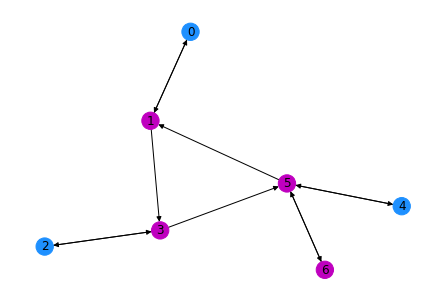

In [32]:
AtomicQC_pulsed = atomicQRegister(physicalRegisters=[pulsed_qubit1, pulsed_qubit2, pulsed_qutrit1],
                                  initnState='000',
                                  name='qubit 1 + qubit 2 + qutrit 1',
                                  connectivity=['Directed', [(1,3),(3,5),(5,1)]],#['All', []],
                                  layout=[(0,0,0), (0,1,0), (1,0,0)]); #build time-dependent quantum register

AtomicQC_pulsed.buildTNHamiltonian(); #build time-dependent N model Hamiltonian
AtomicQC_pulsed.buildNLindbladians(); #build N model Lindabladians
AtomicQC_pulsed.buildNObservables(); #build N model Observables
AtomicQC_pulsed.buildNinitState(); #build N model initial state

# qt.hinton(AtomicQC_pulsed.nHamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(AtomicQC_pulsed.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(AtomicQC_pulsed.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);

AtomicQC_pulsed.simOpts = qt.Options(nsteps=10000, rtol=1e-6, max_step=10e-6);

# AtomicQC_pulsed.playSim(mode='control');
# AtomicQC_pulsed.showResults(figureSize=(14,8));

# plt.plot(times, funcs_lst[7], color='black');
# plt.legend(['00','01','10','11','Pulse',]);
AtomicQC_pulsed.registerMap();

In [33]:
AtomicQC_pulsed.initnState


Quantum object: dims = [[12], [1]], shape = (12, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [34]:
AtomicQC_pulsed._rydbergstates


[1, 3, 5, 6]

In [35]:
AtomicQC_pulsed._HSlist


[[1], [3], [5, 6]]

In [36]:
AtomicQC_pulsed.connectivity


[(1, 3), (3, 5), (5, 1)]

no implemented completely yet


Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = True
Qobj data =
[[ 0.         62.83185307  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [62.83185307  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         62.83185307  0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         62.83185307  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.       

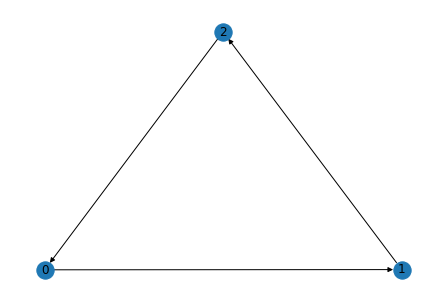

In [37]:
AtomicQC_pulsed.compile()
AtomicQC_pulsed.compileQRegister
AtomicQC_pulsed.tnHamiltonian[4][0]


[Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 

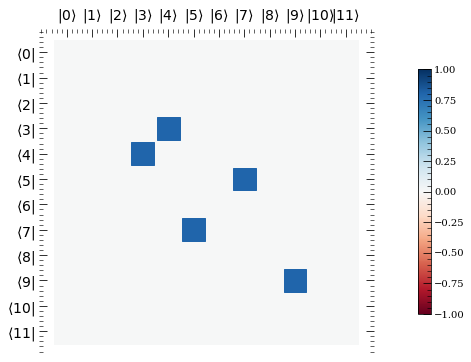

In [38]:
AtomicQC_pulsed._buildInteractingBasis()
qt.hinton(sum(AtomicQC_pulsed._intbasis))

AtomicQC_pulsed._intbasis